# Subcritical Power Plant Flowsheet Example
## Subcritical Boiler Recirculation System

This example demonstrates a steady-state simulation of a subcritical pulverized coal boiler - recirculation system only. The boiler maintains circulation through the steam drum, downcomer, and waterwall by natural circulation. Natural circulation boilers rely on feedwater temperature and the resulting density differences in the drum and vertical tubes in the waterwall to promote circulation by gravity. See the ```supercritical_steam_cycle.py``` for more information on how to assemble the flowsheet.

This example does not represent any particular power plant but should be a reasonable approximation of a subcritical boiler (recirculation system).

## 1. Introduction

This example demonstrates a simulation of a subcritical pulverized coal boiler - recirculation system only. 
```subcritical_boiler.py``` includes four modules (main, create_model, initialize and set_inputs). 

The ```main()``` function creates the Pyomo concrete model and calls for the other functions to build the flowsheet, set inputs, initialize each unit, and solve the flowsheet.

The ```create_model()``` function imports three units from power plant library (drum, downcomer, and waterwall sections). 
Then, it builds two arcs one to connect the drum liquid outlet to the downcomer tube/pipe model, and the other to connect the downcomer outlet to the first section of the waterwall sections model (first from bottom up). The waterwall sections model consists of several tube models interconnected, where, the outlet of each section connects with the next section. Finally, the last section connects with the drum (water_steam_inlet). 

In the drum the water steam mixture is separated, and the vapor leaves the top of the drum (as steam outlet). The separation is calculated using the IAPWS95 steam properties. Feedwater enters the drum from the economizer. The steam leaving the ```drum``` is heated in the superheaters, using hot flue gases, before it passes to the high-pressure turbine inlet as main steam. At this point superheaters have not been included in this simulation.

The ```initialize()``` function uses the initial guess to initialize the models. Each model at the time, and using the solution from the previous interconnected model. 
The ```set_inputs()``` function unfixes the inlet streams of the intermediate units and fixes the appropiate variables (feedwater_inlet flow_mol and enth_mol).

# 2. Problem Statement 

For a given feedwater flowrate and enthalpy, heat duty to each water wall section, drum level, and unit dimensions, calculate the drum steam outlet, slag temperature at each water wall section, inlet pressure of the feedwater system, and recirculation flowrate of the system.

## 2.1. Main Inputs: 
- FeedWater Inlet (F - mol/s, h - j/mol) from the economizer
- Drum: drum level - m, number of downcomers, and dimensions
- Downcomer: number of downcomer tubes, and dimensions
- Waterwall Section: number of water wall sections, slag thickness, and tube dimensions
- Heat Duty (in Watts) from fire side of the boiler, for this simplified simulation heat duty to each water wall section is fixed

## 2.2. Main Outputs:
- Streams (F - mol/s, P - Pa, h - j/mol)
- Feedwater pressure (Pa)
- vapor fraction in raisers (waterwall sections)
- slag temperature (used in heat fire side model in the future) (in K)
- recirculation flowrate of the system (mol/s)

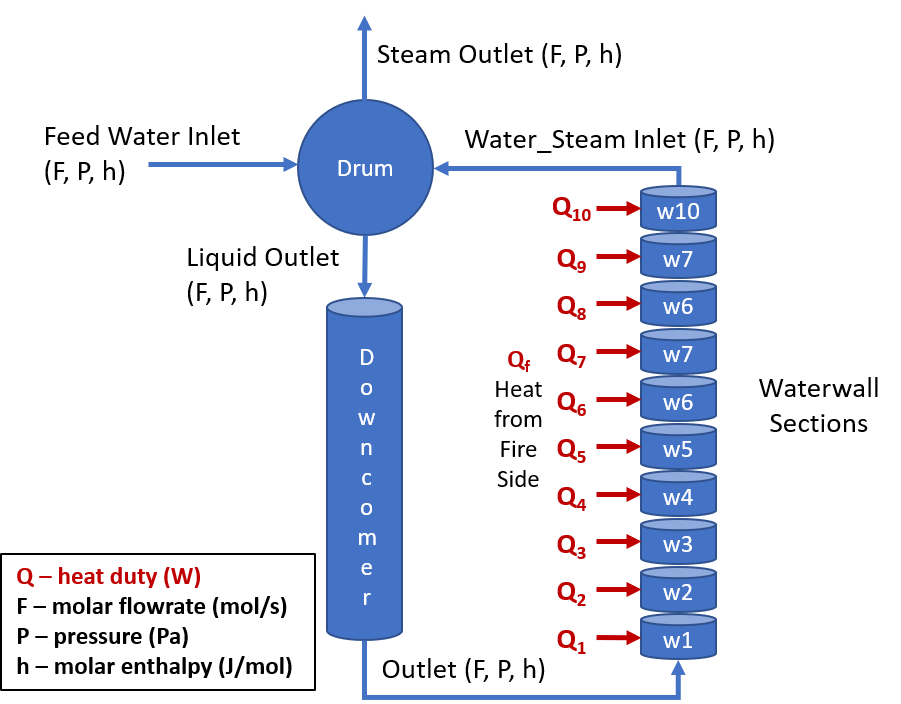

In [1]:
from IPython.display import Image
Image("sub_boiler_1.png")

## 3. Results

In [2]:
import os
# Import Pyomo libraries
import pyomo.environ as pyo
from pyomo.network import Arc
# Import IDAES core
from idaes.core import FlowsheetBlock
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util import model_serializer as ms
import idaes.core.util.scaling as iscale
# Import Unit Model Modules
from idaes.generic_models.properties import iapws95

# Import IDAES standard unit model
import idaes.logger as idaeslog
from idaes.power_generation.unit_models.drum import Drum
from idaes.power_generation.unit_models.downcomer import Downcomer
from idaes.power_generation.unit_models.waterwall_section import \
    WaterwallSection
from idaes.power_generation.properties.flue_gas_ideal import \
    FlueGasParameterBlock

# import subcritical functions
import idaes.power_generation.flowsheets.subcritical_power_plant.subcritical_boiler as sub


# Create a Concrete Model as the top level object
m = pyo.ConcreteModel()
# Add a flowsheet object to the model
m.fs = FlowsheetBlock(default={"dynamic": False})
# Add property packages to flowsheet library
m.fs.prop_water = iapws95.Iapws95ParameterBlock()
m.fs.prop_gas = FlueGasParameterBlock()

# create drum, downcomer, waterwall section models and connections
sub.create_model(m)
# set inputs (equipment dimensions and inlet conditions)
sub.set_inputs(m)
# initialize each model at the time
sub.initialize(m, outlvl=0)

2020-09-14 15:21:35 [WARNING] idaes.core.property_meta: DEPRECATED: IDAES is moving to using Pyomo Units when defining default units, which are used to automatically determine units of measurement for quantities and convert where necessary. Users are strongly encouraged to convert their property packages to use Pyomo Units objects.
2020-09-14 15:21:35 [WARNING] idaes.core.property_meta: DEPRECATED: IDAES is moving to using Pyomo Units when defining default units, which are used to automatically determine units of measurement for quantities and convert where necessary. Users are strongly encouraged to convert their property packages to use Pyomo Units objects.
2020-09-14 15:21:35 [INFO] idaes.init.unknown: Starting initialization...


Initializing from json file


In [3]:
# solve simulation with fixed feedwater inlet flowrate and enthalpy, fixed heat duty to waterwalls, and fixed drum level.
solver = pyo.SolverFactory('ipopt')
optarg = {"tol":1e-6,
         "max_iter":20}
solver.options=optarg

# fix inlets
m.fs.drum.feedwater_inlet.flow_mol[:].fix()
m.fs.drum.feedwater_inlet.pressure[:].unfix()
m.fs.drum.feedwater_inlet.enth_mol[:].fix()

# set scaling parameters
for i in m.fs.ww_zones:
    iscale.set_scaling_factor(m.fs.Waterwalls[i].heat_flux_conv[0], 1e-5)
iscale.calculate_scaling_factors(m)

# solve IDAES flowsheet
results = solver.solve(m, tee=True)

# print custom results
print('\nDrum feedwater inlet')
m.fs.drum.feedwater_inlet.display()
print('\nWaterWall Outlet')
m.fs.drum.water_steam_inlet.display()
print('\ndowncomer inlet')
m.fs.downcomer.inlet.display()
print('\nwaterwall inlet')
m.fs.Waterwalls[1].inlet.display()

2020-09-14 15:21:38 [WARNING] idaes.core.util.scaling: Accessing missing scaling factor for fs.drum.deltaP_gravity[0.0]
2020-09-14 15:21:38 [WARNING] idaes.core.util.scaling: Accessing missing scaling factor for fs.drum.deltaP_contraction[0.0]
2020-09-14 15:21:38 [WARNING] idaes.core.util.scaling: Accessing missing scaling factor for fs.downcomer.N_Re[0.0]
2020-09-14 15:21:38 [WARNING] idaes.core.util.scaling: Accessing missing scaling factor for fs.downcomer.friction_factor_darcy[0.0]
2020-09-14 15:21:38 [WARNING] idaes.core.util.scaling: Accessing missing scaling factor for fs.downcomer.deltaP_gravity[0.0]
2020-09-14 15:21:38 [WARNING] idaes.core.util.scaling: Accessing missing scaling factor for fs.downcomer.deltaP_friction[0.0]
2020-09-14 15:21:38 [WARNING] idaes.core.util.scaling: Accessing missing scaling factor for fs.Waterwalls[1].energy_holdup_slag[0.0]
2020-09-14 15:21:38 [WARNING] idaes.core.util.scaling: Accessing missing scaling factor for fs.Waterwalls[1].N_Re[0.0]
2020-0

   2  0.0000000e+00 3.51e-04 9.99e+00  -1.0 4.95e+03    -  9.90e-01 1.00e+00h  1
   3  0.0000000e+00 8.24e-07 8.99e+01  -1.0 5.04e+00    -  9.90e-01 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   2.7923340439883759e-07    8.2444830695749271e-07
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.7923340439883759e-07    8.2444830695749271e-07


Number of objective function evaluations             = 4
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 4
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 4
Number of inequality constraint Jacobian evaluations = 0
Number o

## 3.1. Sensitivity Analysis 1: Slag Layer Thickness

This sensitivity analysis demonstrates one of the main features of the waterwall section model, by computing the temperature of the slag deposited on the tube surface. The results show that for a given fire side heat duty for each zone the slag layer temperature in each water wall section increases when slag layer thickness increase. 

The slag temperature is a very important parameter, because if slag temperature exceeds the melting temperature, this can cause fast build up of slag layer and may cause damage of the boiler waterwall. 

In [4]:
# slack thickness (upper bound 0.009)
slag_thk = [0.001, 0.002, 0.003]

steam_outlet = []
vap_frac = []
slag_temp = []
count = 0
for i in slag_thk:
    count = count+1
    m.fs.Waterwalls[1].slag_thickness.fix(i)
    m.fs.Waterwalls[2].slag_thickness.fix(i)
    m.fs.Waterwalls[3].slag_thickness.fix(i)
    m.fs.Waterwalls[4].slag_thickness.fix(i)
    m.fs.Waterwalls[5].slag_thickness.fix(i)
    m.fs.Waterwalls[6].slag_thickness.fix(i)
    m.fs.Waterwalls[7].slag_thickness.fix(i)
    m.fs.Waterwalls[8].slag_thickness.fix(i)
    m.fs.Waterwalls[9].slag_thickness.fix(i)
    m.fs.Waterwalls[10].slag_thickness.fix(i)

    results = solver.solve(m, tee=False)
    if results.solver.termination_condition == \
        pyo.TerminationCondition.optimal:
        print('iter '+str(count)+ ' = EXIT- Optimal Solution Found.')
    else:
        print('iter '+str(count)+ ' = infeasible')
    steam_outlet.append(pyo.value(m.fs.drum.steam_outlet.flow_mol[0]))
    vap_frac.append(pyo.value(m.fs.Waterwalls[10].control_volume.properties_out[0].vapor_frac))
    slag_temp.append(pyo.value(m.fs.Waterwalls[10].temp_slag_boundary[0]))

iter 1 = EXIT- Optimal Solution Found.
iter 2 = EXIT- Optimal Solution Found.
iter 3 = EXIT- Optimal Solution Found.


## 3.1. Results
As it can be observed below, the steam flowrate and vapor fraction have not been impacted by incrementing the slag thickness, however, the slag temperature increased considerably. In reality, the slag thickness impacts the heat transfer in the system, therefore, the heat to the water wall must change. The model did not capture this issue because heat transfer is fixed. An integrated fire-water side model would capture this phenomenon and change the heat to the waterwall, obtaning different steam outlet and vapor fractions.

In [5]:
print('Vapor flowrate from drum mol/s')
print(steam_outlet)
print('\nVapor fraction from waterwall section 10')
print(vap_frac)
print('\nSlag temperature in K')
print(slag_temp)

Vapor flowrate from drum mol/s
[4630.609800000024, 4630.609800000017, 4630.6097999999965]

Vapor fraction from waterwall section 10
[0.023214476610626433, 0.02321447664192562, 0.023214476674248332]

Slag temperature in K
[665.5158858153821, 729.2723629886863, 793.03721107368]


## 3.2. Sensitivity Analysis 2: Boiler Load

The heat transfer and energy balance play a very important role in this system, for example, since the drum level and pressure are fixed, the heat transfer rate (or heat duty) to the water side will determine the amount of steam produced.

This sensitivity analysis demonstrates that increasing the boiler load or coal flowrate (in this case incrementing the heat duty) results in increasing the feedwater flowrate and therefore the flowrate of steam leaving the drum unit.

Degrees of Freedom:
In this case, the system is fully determined by fixing the feedwater_inlet enthalpy and pressure, drum level, and heat duty to water wall. Then we perform several simulations by gradually increasing the heat duty to the waterwalls and calculating the feedwater_inlet flowrate for each case.

In [6]:
# reload initial point
from idaes.core.util import model_serializer as ms
ms.from_json(m, fname="subcritical_boiler_init.json.gz")

# create dictionaries to store results
vap_frac = []  # vapor fraction outlet (zone 10)
flow = []  # feedwater flowrate
recir_flow = []  # recirculation flow
recir_ratio = []  # recirculation ratio
slag_temp = []  # slag layer temperature

# incrementing 10 % each run
flow_it = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
           1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4,
           2.5, 2.6, 2.7, 2.8, 2.9, 3.0]
count1=0
for i in flow_it:
    count1 = count1+1
    m.fs.Waterwalls[1].heat_fireside[:].fix(2.3e7*i)
    m.fs.Waterwalls[2].heat_fireside[:].fix(1.5e7*i)
    m.fs.Waterwalls[3].heat_fireside[:].fix(6.8e6*i)
    m.fs.Waterwalls[4].heat_fireside[:].fix(1.2e7*i)
    m.fs.Waterwalls[5].heat_fireside[:].fix(1.2e7*i)
    m.fs.Waterwalls[6].heat_fireside[:].fix(1.2e7*i)
    m.fs.Waterwalls[7].heat_fireside[:].fix(1.0e7*i)
    m.fs.Waterwalls[8].heat_fireside[:].fix(9.9e6*i)
    m.fs.Waterwalls[9].heat_fireside[:].fix(2.1e7*i)
    m.fs.Waterwalls[10].heat_fireside[:].fix(2.0e7*i)
    # unfix flowrate
    m.fs.drum.feedwater_inlet.flow_mol[:].unfix()
    m.fs.drum.feedwater_inlet.pressure[:].fix()
    m.fs.drum.feedwater_inlet.enth_mol[:].fix()
    results = solver.solve(m, tee=False)
    if results.solver.termination_condition == \
        pyo.TerminationCondition.optimal:
        print('iter '+str(count1)+ ' = EXIT- Optimal Solution Found.')
    else:
        print('iter '+str(count1)+ ' = infeasible')
    vap_frac.append(pyo.value(m.fs.Waterwalls[10].control_volume.
                              properties_out[0].vapor_frac))
    # recirculation flowrate
    recir_flow.append(pyo.value(m.fs.drum.flash.liq_outlet.flow_mol[0]))
    # recirculation ratio
    recir_ratio.append(pyo.value(m.fs.drum.flash.liq_outlet.flow_mol[0]/m.fs.drum.feedwater_inlet.flow_mol[0]))
    # feedwater flowrate
    flow.append(pyo.value(m.fs.drum.feedwater_inlet.flow_mol[0]))
    # slag layer temperature
    slag_temp.append(pyo.value(m.fs.Waterwalls[10].temp_slag_boundary[0]))



iter 1 = EXIT- Optimal Solution Found.
iter 2 = EXIT- Optimal Solution Found.
iter 3 = EXIT- Optimal Solution Found.
iter 4 = EXIT- Optimal Solution Found.
iter 5 = EXIT- Optimal Solution Found.
iter 6 = EXIT- Optimal Solution Found.
iter 7 = EXIT- Optimal Solution Found.
iter 8 = EXIT- Optimal Solution Found.
iter 9 = EXIT- Optimal Solution Found.
iter 10 = EXIT- Optimal Solution Found.
iter 11 = EXIT- Optimal Solution Found.
iter 12 = EXIT- Optimal Solution Found.
iter 13 = EXIT- Optimal Solution Found.
iter 14 = EXIT- Optimal Solution Found.
iter 15 = EXIT- Optimal Solution Found.
iter 16 = EXIT- Optimal Solution Found.
iter 17 = EXIT- Optimal Solution Found.
iter 18 = EXIT- Optimal Solution Found.
iter 19 = EXIT- Optimal Solution Found.
iter 20 = EXIT- Optimal Solution Found.


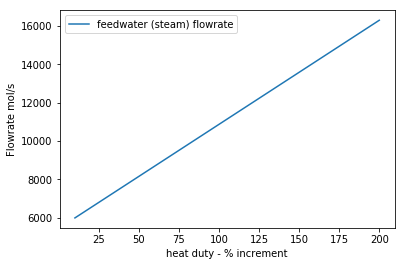

In [7]:
# import plotting libraries
import matplotlib.pyplot as plt
import numpy as np

x = []
for i in flow_it:
    x.append((i-1)*100)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(x, flow, label=str('feedwater (steam) flowrate'))
plt.legend()
ax.set_xlabel('heat duty - % increment')
ax.set_ylabel('Flowrate mol/s')
plt.show()

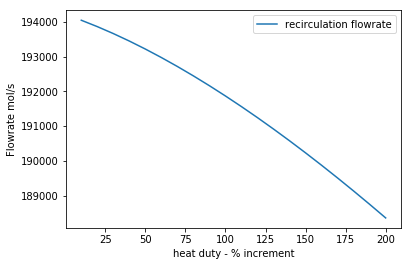

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(x, recir_flow, label=str('recirculation flowrate'))
plt.legend()
ax.set_xlabel('heat duty - % increment')
ax.set_ylabel('Flowrate mol/s')
plt.show()

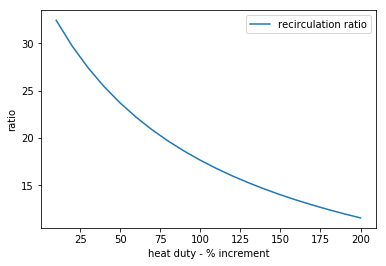

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(x, recir_ratio, label=str('recirculation ratio'))
plt.legend()
ax.set_xlabel('heat duty - % increment')
ax.set_ylabel('ratio')
plt.show()

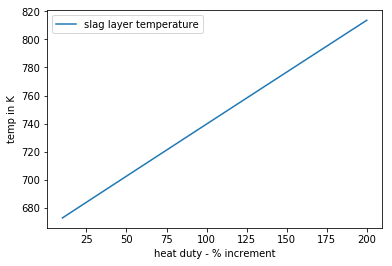

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(x, slag_temp, label=str('slag layer temperature'))
plt.legend()
ax.set_xlabel('heat duty - % increment')
ax.set_ylabel('temp in K')
plt.show()

## 3.2. Results
As can be observed above, the feedwater flowrate and steam flowrate leaving the drum increase due to the increase of heat duty. The recirculation flowrate decreases slightly due to the increase of the friction force inside the waterwall tubes, which is caused by the increase in vapor fraction.
The recirculation ratio, defined as the ratio of flowrate of water in the circuity to the flowrate of the feedwater, decreases as heat duty increases.
Finally, the slag layer temperature increases as the heat duty increases. Total heat transfer resistance includes the contributions from the slag layer, tube metal, and convection of the fluid with the slag layer as the highest contributor. Thus, since the slag thickness is fixed, the total heat transfer resistance does not change much. Therefore, as the heat duty is increased, the temperature difference between the slag layer and fluid becomes larger, while the fluid temperature remains almost constant.